<h1>Stock Price Prediction using SVM</h1>
<p><b>Introduction: </b>The programme below uses a Support Vector Machine model to predict positive movements (upward trend) of Etherium price using a 5-year dataset from 2018-01-01 to  2023-04-30. The programme is comprised of the following sections:</p>
<ol>
    <li>Data preprocessing (incl. Feature engineering)</li> 
    <li>Feature selection</li> 
    <li>Model build and grid search</li> 
    <li>Results and conclusions</li>     
</ol>
<p>Explanation of each step is embedded in the markdown cells.</p>
<h2>Import Libraries</h2>
<p>Importing the libraries required for the program.</p>

In [1]:
# Base Libraries
import pandas as pd
import numpy as np

# Import yahoo finance library
import yfinance as yf

# Plotting
import matplotlib.pyplot as plt
import cufflinks as cf
import seaborn as sns
plt.style.use('seaborn')
# plt.rcParams['figure.figsize'] = (20,7)
# plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
                                    train_test_split, 
                                    GridSearchCV, 
                                    TimeSeriesSplit, 
                                    cross_val_score,
                                    StratifiedKFold
                                    )

# Regressor
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet

# Feature Selector
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

# Classifier
from sklearn.svm import SVC

# metrics
from sklearn.metrics import (precision_recall_curve, 
                             roc_curve, 
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             mean_squared_error,
                             f1_score
                            )
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             recall_score,
                             precision_score,
                             roc_auc_score,
                             auc
                            )
from sklearn.metrics import (classification_report, 
                             confusion_matrix 
                            )
# Machine info & package version
from watermark import watermark
%load_ext watermark
%watermark -a "Siqi He" -u -d -v -m -iv                            
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Author: Siqi He

Last updated: 2023-06-01

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.9.0

Compiler    : Clang 12.0.0 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

numpy     : 1.23.0
seaborn   : 0.12.2
yfinance  : 0.2.9
pandas    : 1.5.3
cufflinks : 0.17.3
matplotlib: 3.6.3



/var/folders/v7/bsvsdxhj1k71r1845zd3y0m40000gn/T/ipykernel_13102/4025060798.py:12: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



<h2>Section 1: Data Preprocessing and Feature Engineering</h2>
<h3>1.1 Retrieve Data</h3>
<p>First, we retrieve data from the Yahoo Finance database. The selected ticker is Cryptocurrency Etherium.</p>
<ul>
    <li><b>Period:</b> 5 years (Apr-18 to Apr-23)</li>
    <li><b>Frequency:</b> Daily</li>
    <li><b>Ticker:</b> Etherium</li>
</ul>

In [2]:
# Fetch the data
data = yf.download('ETH-USD', period='1d', 
                   start='2018-01-01', end='2023-04-30',progress=False)
# View dataset
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01 00:00:00+00:00,755.757019,782.530029,742.004028,772.640991,772.640991,2595760128
2018-01-02 00:00:00+00:00,772.346008,914.830017,772.346008,884.443970,884.443970,5783349760
2018-01-03 00:00:00+00:00,886.000000,974.471008,868.450989,962.719971,962.719971,5093159936
2018-01-04 00:00:00+00:00,961.713013,1045.079956,946.085999,980.921997,980.921997,6502859776
2018-01-05 00:00:00+00:00,975.750000,1075.390015,956.325012,997.719971,997.719971,6683149824
...,...,...,...,...,...,...
2023-04-25 00:00:00+00:00,1842.204346,1877.484985,1805.322876,1866.753662,1866.753662,8677255481
2023-04-26 00:00:00+00:00,1866.148926,1962.567627,1792.463867,1866.564209,1866.564209,14356524696
2023-04-27 00:00:00+00:00,1866.693237,1936.945190,1863.147949,1908.786377,1908.786377,14008145806


<p>We can see that the dataset has 1945 observations (daily) and 6 fields.</p>
<p>Plotting the 'Close' price to see overall trend of the price movements.</p>

In [3]:
# Preliminary exploration
layout1 = cf.Layout(height=500, width=800, title='Etherium Close price over 5 years')
data['Close'].iplot(kind='line', layout=layout1)

<p>At the moment the <b>Date</b> column is set as the dataframe index. Our analysis won't be using the datetime directly as a predictor, but concept of time will be baked into the features with an implicit time order - such as returns, lagged returns, momentum, etc.</p>

In [4]:
# Move Date to column and delete, reset index
data.reset_index(inplace=True)
df = data.drop(['Date'], axis=1)

# View dataset
df

,Open,High,Low,Close,Adj Close,Volume
0,755.757019,782.530029,742.004028,772.640991,772.640991,2595760128
1,772.346008,914.830017,772.346008,884.443970,884.443970,5783349760
2,886.000000,974.471008,868.450989,962.719971,962.719971,5093159936
3,961.713013,1045.079956,946.085999,980.921997,980.921997,6502859776
4,975.750000,1075.390015,956.325012,997.719971,997.719971,6683149824
...,...,...,...,...,...,...
1940,1842.204346,1877.484985,1805.322876,1866.753662,1866.753662,8677255481
1941,1866.148926,1962.567627,1792.463867,1866.564209,1866.564209,14356524696
1942,1866.693237,1936.945190,1863.147949,1908.786377,1908.786377,14008145806
1943,1909.273071,1923.199219,1876.291870,1892.512817,1892.512817,7691759733


<h2>1.2 Feature Engineerng</h2>
<p>Now we proceed to creating features to be selected into the SVM model. Based on the existing fields in the dataset, we calculate the following features:</p>
<ul>
    <li>Intraday price range</li>
    <li>Return</li>
    <li>Lagged returns: 1, 2, 3, ... 20 days</li>
    <li>Sign of return</li>
    <li>Sign of lagged returns</li>
    <li>Momentum, price change over 1, 2, 3, 4, 5, 20, 60 days</li>
    <li>Moving average: over 1, 2, 3, 4, 5, 20, 60 days</li>
    <li>Exponential moving average</li>
</ul>
<p>The last block creates the <b>target variable</b>, which is the trend of movement for the stock of a certain day. It is a <b>binary value</b> of <b>1 (when the price moves up)</b> or <b>0 (when the price stays flat or drops)</b>. Due to how the returns are calculated (today's Close price/yesterday's close price), the target value for yesterday should be today's return, target value for today being tomorrow's return, etc. Therefore to create the target field, we take the sign of <b>next day's return</b> and set the value to 1 if positive, 0 otherwise.</p>

<p>On the other hand, the target column we use for Embedded feature selection is created as the field "FS_target". Due to our use of <b>regularised regression methods</b>, we let next day's return (rather than its sign) be the target used for feature selection regressions.</p>


In [5]:
# The below function takes the dataframe as an imput creates the list of features specified.

def create_features(df):
    '''
    Takes in a YahooFinance ticker dataset and engineers a set of features,
    new features are saved as new columns in the dataset for further selection.
    '''
    
    # (1) O-C, H-L: Intra day price range
    df['O-C'] = df['Close']/df['Open'] - 1
    df['H-L'] = df['High']/df['Low'] - 1

    # (2) Return
    # (3) Sign: Sign of return or momentum
    df['RET'] = np.log(df['Close']/df['Close'].shift(1))
    df['Sign'] = np.where(df['RET']>0, 1, 0) # Change to np.where

    # (4) Past returns: Lagged i day returns, i=1, 2, 3, ...20
    # (5) Sign: Sign of return or momentum for past returns
    for i in range(1,6):
        df['RET'+ str(i)] = df['RET'].shift(i)
        # df['Sign'+ str(i)]= np.sign(df['RET'+ str(i)])

    # (6) Momentum: Price change over i period, i = 1, 2, 3, 4, 5, 20, 60 (days)
    # (7) Moving Average: Simple moving average, i = 1, 2, 3, 4, 5, 20, 60 (days)

    for i in [1, 2, 3, 4, 5, 20, 60]:
        df['Momentum' + str(i)] = df['Close'] / df['Close'].shift(i) - 1
        df['MA'+ str(i)] = df['Close'] / df['Close'].rolling(window=i).mean() - 1

    # (8) Exponential MA: Initialise the first EMA to be the Closing price
          ## Alpha = 2/(len(df)+1)
    for j, row in df.iterrows():
        if j==0:
            df.loc[j,'EMA'] = df.loc[j,'Close']
        else:
            df.loc[j,'EMA'] = df.loc[j-1,'EMA'] + \
                                      2/(len(df)+1)*(df.loc[j,'Close']-df.loc[j-1,'EMA'])
    df['EMA'] = df['Close'] / df['EMA'] - 1

    # MA1 (1-day rolling average) column is effectively each Closing price
    # hence duplicate to 'Close' column
    df.drop(['MA1'], axis=1,inplace=True) 

    # Create new column for dependent variable
    ## The dependent variable is takes a binary value of:
    ### =1 when the whether today's price moves up
    ### =0 when today's price stays flat or moves down compared to yesterday
    df['Label'] = np.where(df['RET'].shift(-1)>0, 1, 0)
    
    # Drop observations with NaN values
    df.dropna(axis='index', inplace=True)
    
    return df


<p>Next we run the above function on the dataset to create the features.</p>

In [6]:
# Features
df = create_features(df)
display(df.shape)

(1885, 30)

<p>We can see that the new dataset including new features now has 1884 observations and 32 fields.</p>
<p>The initial fields, together with the target columns can now be dropped as they are not candidates for the feature selection process.</p>

In [7]:
# Drop OHLCV and Labels
X_raw = df.drop(['Adj Close','Open', 'High', 'Low', 'Close'
                 , 'Volume', 'Label'], axis=1)

X_raw

,O-C,H-L,RET,Sign,RET1,RET2,RET3,RET4,RET5,Momentum1,...,MA3,Momentum4,MA4,Momentum5,MA5,Momentum20,MA20,Momentum60,MA60,EMA
60,-0.017104,0.028103,-0.017752,0,0.019685,-0.026614,0.010243,0.028594,0.005097,-0.017596,...,-0.005299,-0.014335,-0.010139,0.014255,-0.010981,-0.004140,-0.027122,0.108992,-0.137638,0.090488
61,0.000600,0.015490,0.000434,1,-0.017752,0.019685,-0.026614,0.010243,0.028594,0.000434,...,-0.005646,-0.023956,-0.003655,-0.013908,-0.007782,0.052249,-0.029046,-0.030775,-0.136869,0.090860
62,0.012254,0.032929,0.010967,1,0.000434,-0.017752,0.019685,-0.026614,0.010243,0.011027,...,0.007470,0.013423,0.003984,-0.013193,0.005857,-0.002336,-0.018226,-0.099761,-0.125943,0.102772
63,-0.015184,0.019215,-0.015106,0,0.010967,0.000434,-0.017752,0.019685,-0.026614,-0.014993,...,-0.006415,-0.021229,-0.005737,-0.001771,-0.008875,0.009969,-0.033407,-0.129713,-0.137202,0.086142
64,-0.043178,0.054185,-0.043982,0,-0.015106,0.010967,0.000434,-0.017752,0.019685,-0.043029,...,-0.034075,-0.046568,-0.037335,-0.063344,-0.039196,-0.115434,-0.069381,-0.181182,-0.171805,0.039365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,0.013326,0.039972,0.012938,1,-0.010421,-0.006513,0.013012,-0.049098,0.003451,0.013022,...,0.005149,0.009056,0.002849,-0.039290,0.004084,-0.022188,-0.039102,0.160647,0.052024,0.278520
1941,0.000223,0.094899,-0.000101,0,0.012938,-0.010421,-0.006513,0.013012,-0.049098,-0.000101,...,0.004235,-0.004089,0.003780,0.008954,0.002197,-0.003395,-0.039042,0.170322,0.049240,0.278025
1942,0.022550,0.039609,0.022368,1,-0.000101,0.012938,-0.010421,-0.006513,0.013012,0.022620,...,0.014933,0.025093,0.020078,0.018438,0.021077,0.023129,-0.018395,0.163315,0.070287,0.306522
1943,-0.008778,0.025000,-0.008562,0,0.022368,-0.000101,0.012938,-0.010421,-0.006513,-0.008526,...,0.001707,0.027000,0.004703,0.016353,0.009085,0.023257,-0.027839,0.157977,0.058608,0.294990


<h4>Target or Label Definition</h4>

In [8]:
# label for final SVM model
y = np.array(df['Label'])
y

array([1, 1, 0, ..., 0, 1, 0])

<h2>Section 3. Subset Selection</h2>
<h3>3.1. Filter Method: Removing features with high correlation.</h3>
<p>Here we plot the correlation matrix for all features. Due to having quite a few candidates, we implement a threshold of 0.7. In the heatmap below, all pairs of features with >0.7 correlation is highlighted in red.</p>

Text(0.5, 1.0, 'Feature Set Correlations')

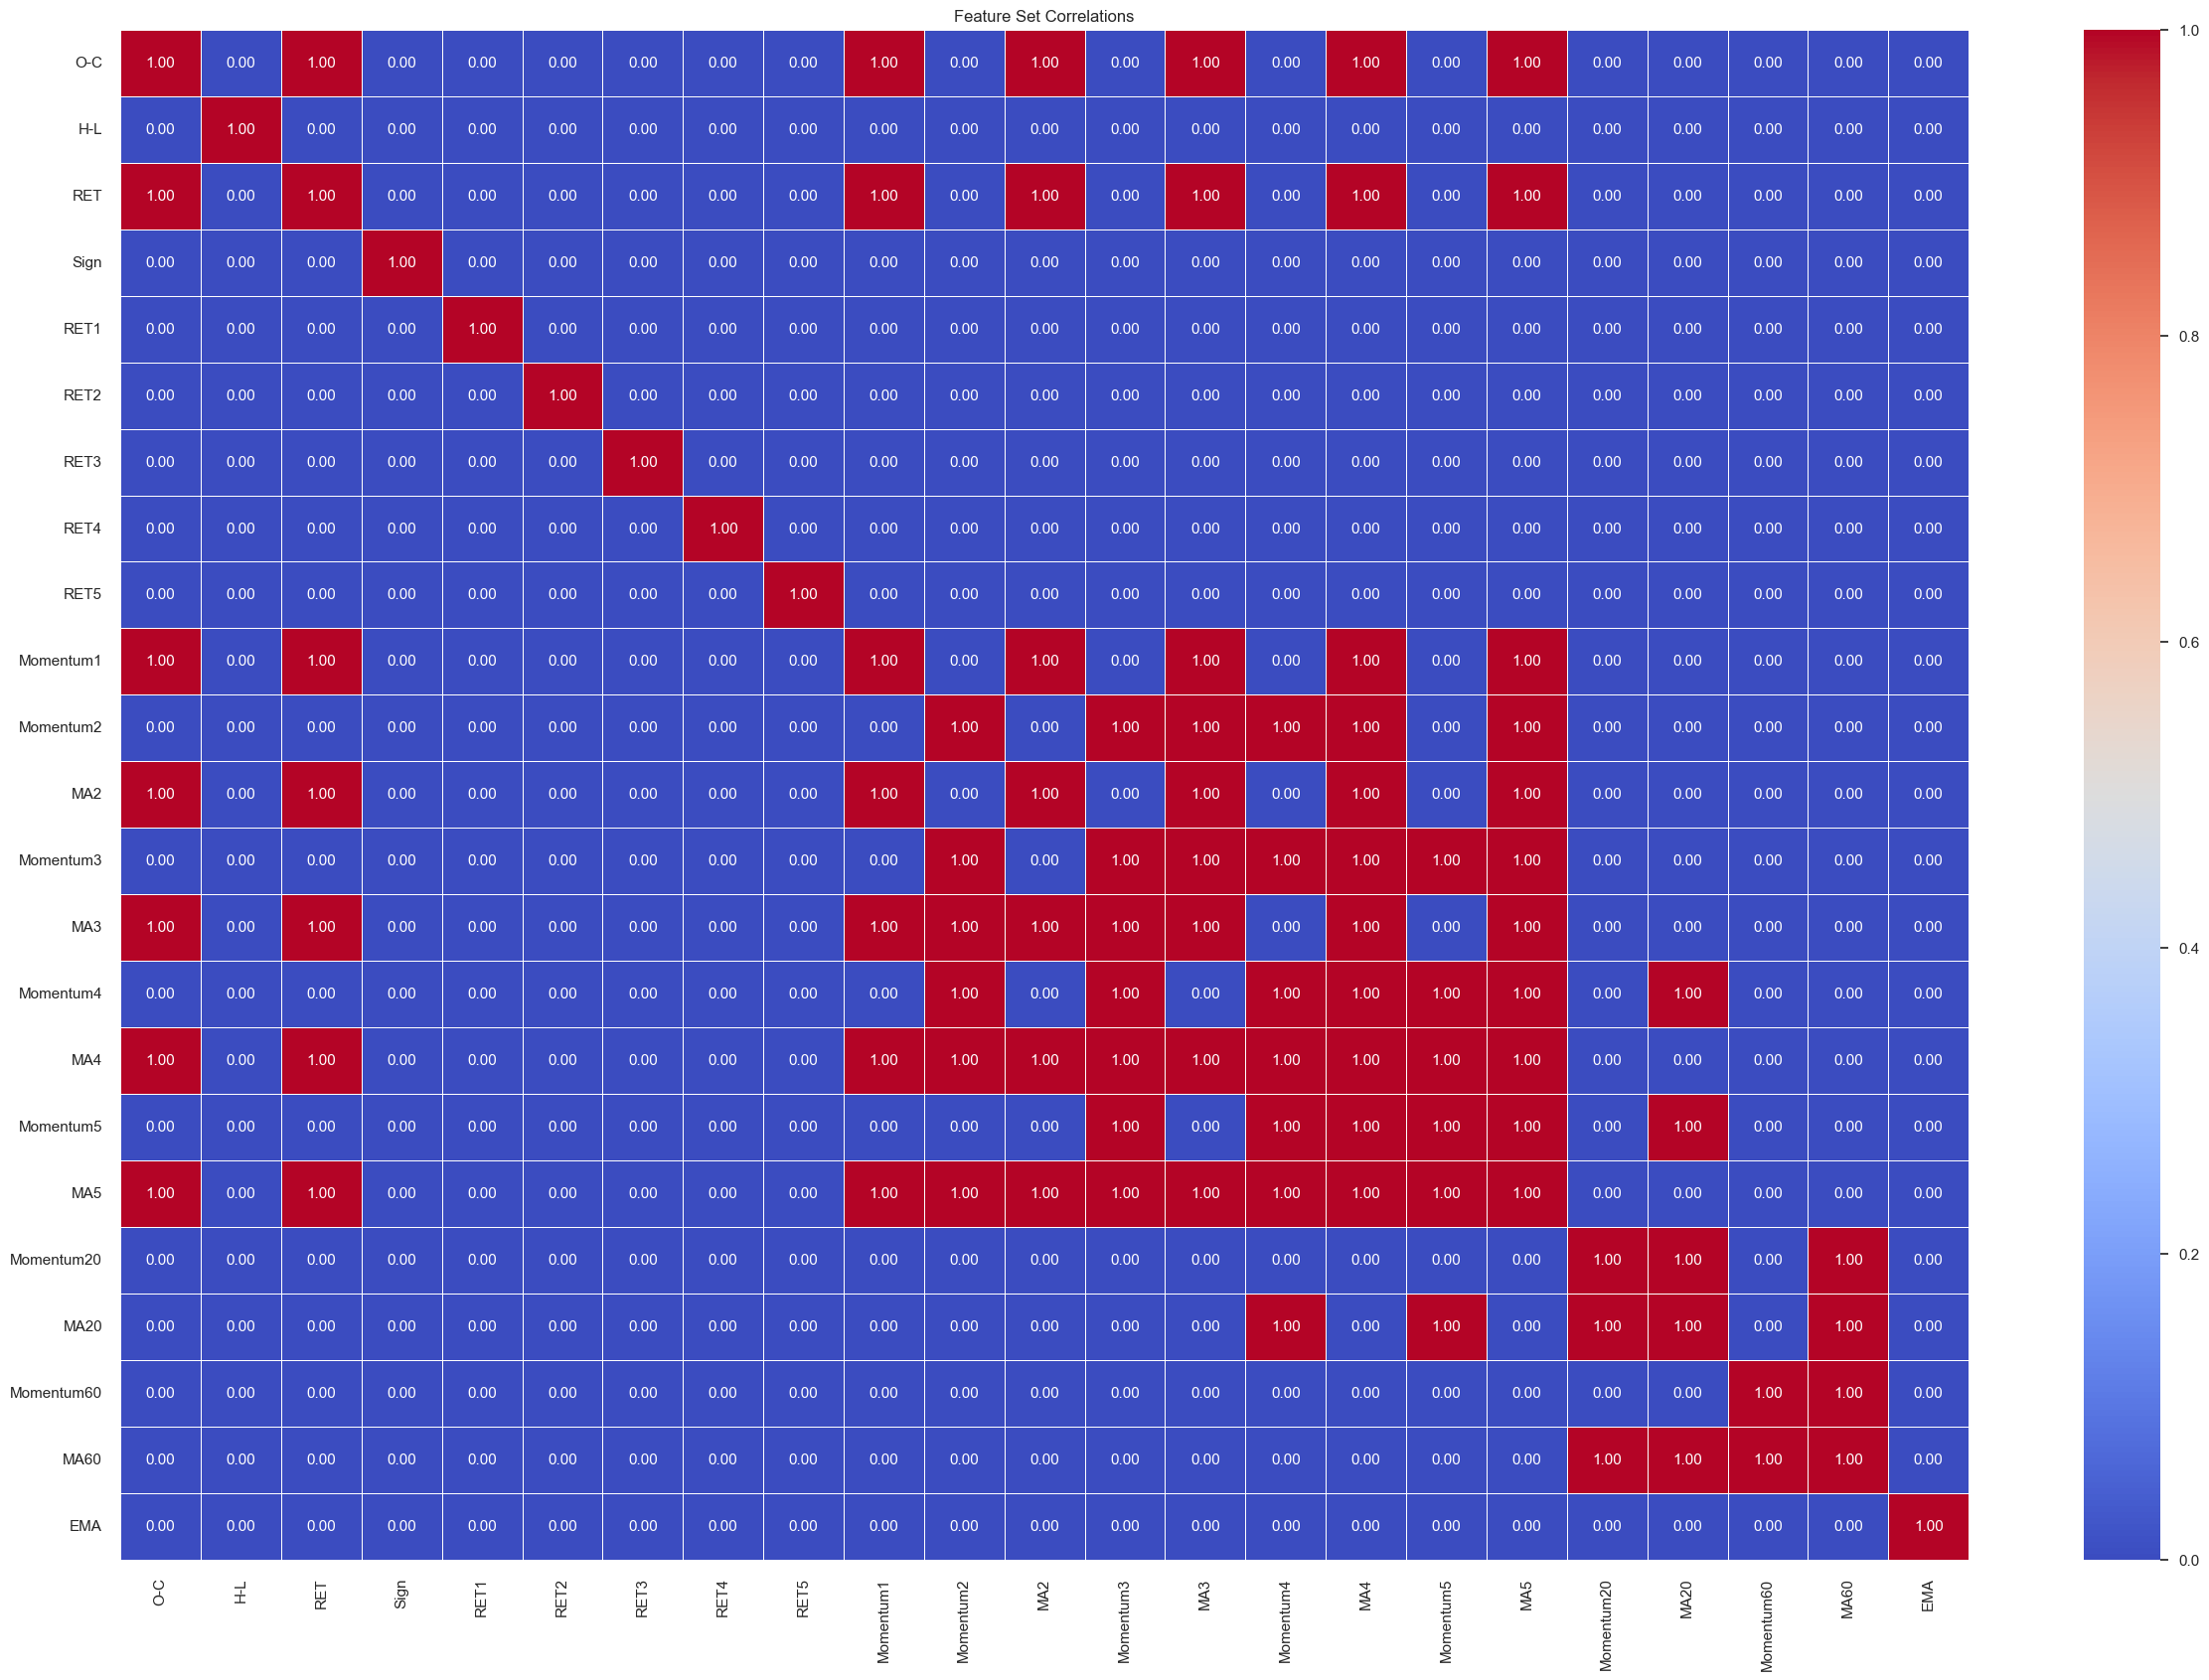

In [9]:
# Remove features of input variables that are highly correlated
sns.set(rc={'figure.figsize':(30,20)})

sns.heatmap(X_raw.corr()>0.7,
           annot=True,
           annot_kws={"size": 11}, 
           fmt=".2f", 
           linewidth=.5, 
           cmap="coolwarm", 
           cbar=True); 
plt.title('Feature Set Correlations')

<p>Accordingly, the following features are removed from the candidates: MA3, MA4, MA5, MA60, Momentum1, Momentum2, Momentum4, Momentum5, O-C. The decision is made taking into account that we want to still keep a variety of candidates in our pool. In this case amongst the moving averages we are left with <b>MA2</b> and <b>MA20</b>, amongst Momentums we keep <b>Momentum3</b> and <b>Momentum60</b>.</p>

In [10]:
# Drop the highly correlated features
to_drop = ['MA3', 'MA4','MA5','MA60','RET',
           'Momentum1','Momentum2','Momentum20','Momentum4','Momentum5', 'O-C']
X = X_raw.drop(to_drop, axis=1)

# Record feature names
feature_names = X.columns

# Display the features set
X

,H-L,Sign,RET1,RET2,RET3,RET4,RET5,MA2,Momentum3,MA20,Momentum60,EMA
60,0.028103,0,0.019685,-0.026614,0.010243,0.028594,0.005097,-0.008876,-0.024380,-0.027122,0.108992,0.090488
61,0.015490,1,-0.017752,0.019685,-0.026614,0.010243,0.028594,0.000217,0.002369,-0.029046,-0.030775,0.090860
62,0.032929,1,0.000434,-0.017752,0.019685,-0.026614,0.010243,0.005483,-0.006331,-0.018226,-0.099761,0.102772
63,0.019215,0,0.010967,0.000434,-0.017752,0.019685,-0.026614,-0.007553,-0.003698,-0.033407,-0.129713,0.086142
64,0.054185,0,-0.015106,0.010967,0.000434,-0.017752,0.019685,-0.021987,-0.046982,-0.069381,-0.181182,0.039365
...,...,...,...,...,...,...,...,...,...,...,...,...
1940,0.039972,1,-0.010421,-0.006513,0.013012,-0.049098,0.003451,0.006469,-0.003988,-0.039102,0.160647,0.278520
1941,0.094899,0,0.012938,-0.010421,-0.006513,0.013012,-0.049098,-0.000051,0.002418,-0.039042,0.170322,0.278025
1942,0.039609,1,-0.000101,0.012938,-0.010421,-0.006513,0.013012,0.011184,0.035832,-0.018395,0.163315,0.306522
1943,0.025000,0,0.022368,-0.000101,0.012938,-0.010421,-0.006513,-0.004281,0.013799,-0.027839,0.157977,0.294990


<p>Once more we plot the correlation matrix to check for any high correlations. All seems fine and no pair has a correlation > 0.7.</p>

Text(0.5, 1.0, 'Feature Set Correlations')

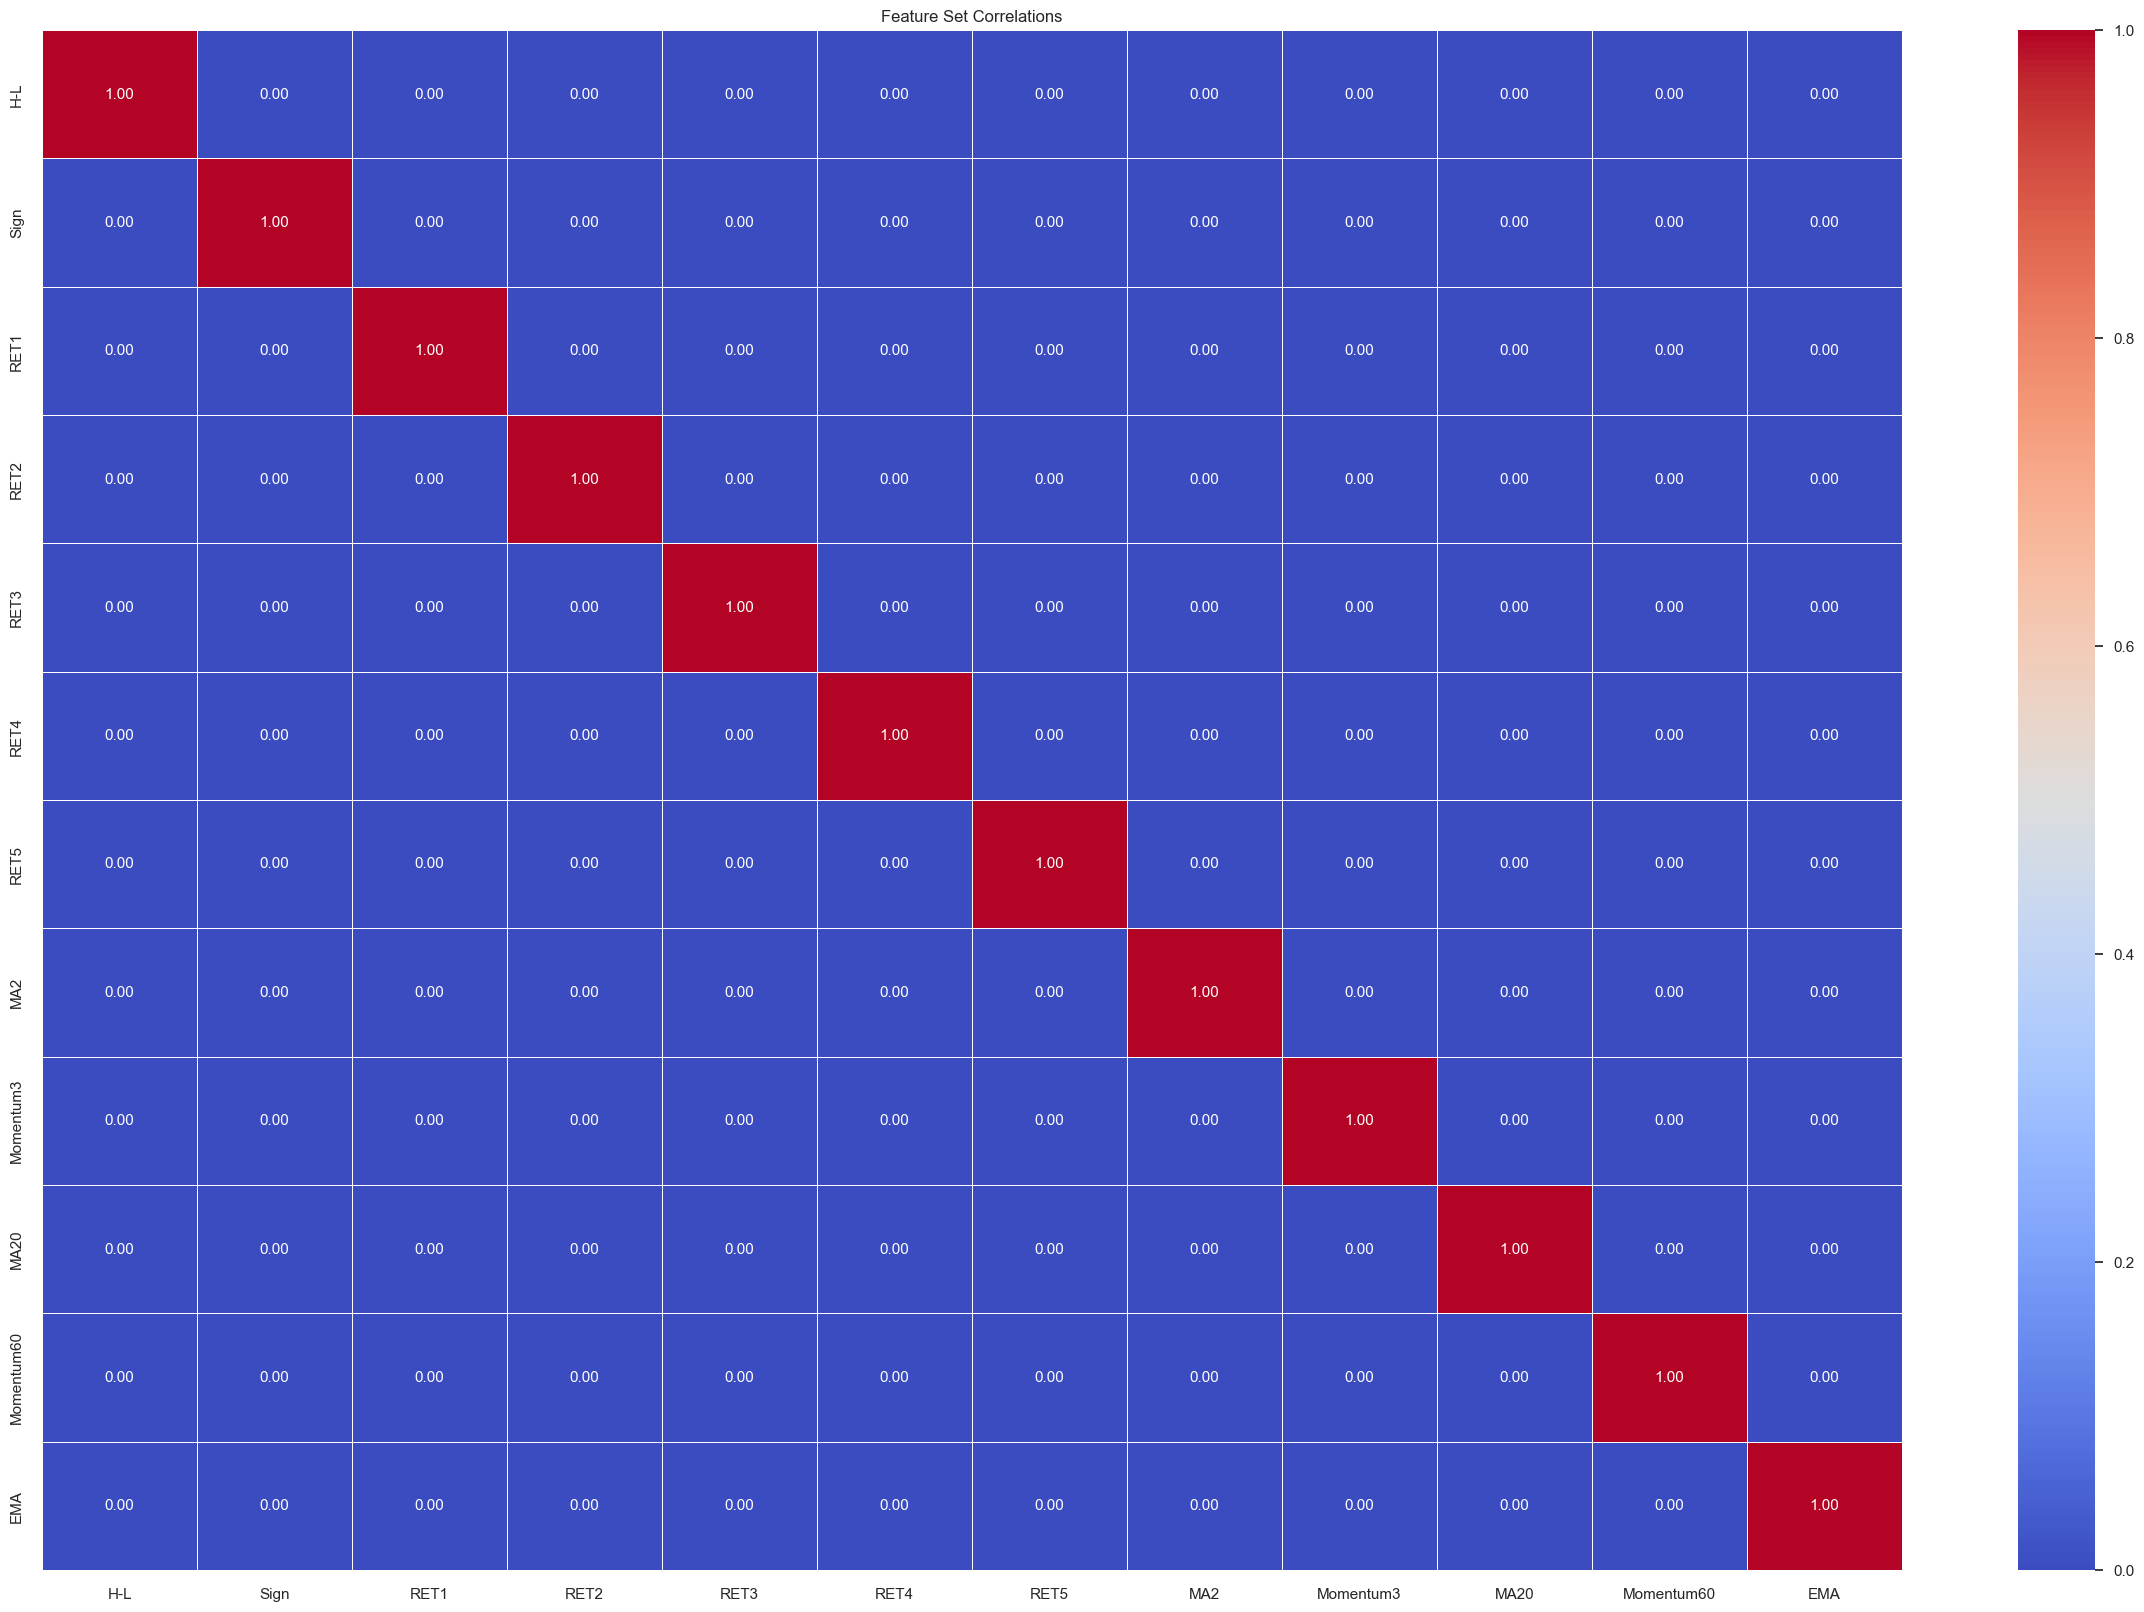

In [11]:
# View correlation matrix again: the new heatmap shows no correlations > 0.9
sns.set(rc={'figure.figsize':(30,20)})

sns.heatmap(X.corr()>0.7,
           annot=True,
           annot_kws={"size": 11}, 
           fmt=".2f", 
           linewidth=.5, 
           cmap="coolwarm", 
           cbar=True); 
plt.title('Feature Set Correlations')


<p>Hence we now have a list of candidate features ready for the next step of feature selection:</p>
<ul>
    <li>H-L</li> 
    <li>Sign</li> 
    <li>Lagged returns: RET1, RET2, RET3, RET4, RET5</li> 
    <li>Momentum3, Momentum60</li> 
    <li>Moving average, 2-day and 20-day: MA2, MA20</li>  
</ul>

<h3>3.2. Embedded Method: LASSO, RIDGE with Logistic Regression</h3>
<p>As the target variables are binary, we use Logistic Regression with L1, L2 and ElasticNet penalties to perform embedded feature selection.</p>

<h4>3.2.1. EDA for Feature Scaling</h4>
<p>First we decide on the appropriate scaling method to use.</p>

In [12]:
# Decide which scaling to use
X.describe().T

,count,mean,std,min,25%,50%,75%,max
H-L,1885.0,0.063925,0.050501,0.006090,0.033337,0.051162,0.079305,0.760822
Sign,1885.0,0.508753,0.500056,0.000000,0.000000,1.000000,1.000000,1.000000
RET1,1885.0,0.000421,0.048814,-0.550732,-0.020863,0.000752,0.025132,0.230695
RET2,1885.0,0.000412,0.048817,-0.550732,-0.020909,0.000752,0.025132,0.230695
RET3,1885.0,0.000405,0.048815,-0.550732,-0.020909,0.000752,0.025132,0.230695
RET4,1885.0,0.000421,0.048819,-0.550732,-0.020909,0.000758,0.025177,0.230695
RET5,1885.0,0.000416,0.048819,-0.550732,-0.020909,0.000758,0.025177,0.230695
MA2,1885.0,0.000213,0.024339,-0.268611,-0.010431,0.000376,0.012565,0.114839
Momentum3,1885.0,0.004673,0.082357,-0.443788,-0.036395,0.003480,0.049264,0.424260
MA20,1885.0,0.008023,0.128704,-0.497104,-0.066850,0.003309,0.081847,0.597091


<p>From the descriptive statistics we see no significant outliers to the dataset, suggesting that the both the MinMaxScaler and the StandardScaler can potentially work. However, as we are predicting a binary direction of movement rather an absolute value, we deem the StandardScaler is more suited for purpose, as it reduces the variance to 1, weakening the power of large values.</p>

<h4>3.2.2. Creating regression class for Regularised Logistic Regression</h4>
<p>The Regression Class below helps initialise a regression instance, which is then able to fit the dataset using the <b>fit_predict</b> method. The <b>plot_coeff</b> method applies the chosen penalty to the logistic regression estimator and reduces features accordingly. The strength of the penalty is decided by the list of values in <b>C_range</b>. Finally the "die-off" process of the feature coefficients are plotted with the 1/C_range, which is equivalent to $\lambda$ value in regularised linear regression (C=$\lambda$).<p> 

In [13]:
class Regression:
    def __init__(self, X, y, testsize=0.20):

        self.X = X
        self.y = y
        self.testsize = testsize
        
        # split training and testing dataset
        self.X_train,self.X_test,self.y_train,self.y_test=train_test_split(self.X, 
                                                                            self.y, 
                                                                            test_size=self.testsize, 
                                                                            random_state=0, 
                                                                            shuffle=False)
    
    # fit and predict
    def fit_predict(self, estimator, transformer):
        
        try:
            # subsume estimators and transformer into a pipeline
            model = Pipeline([
            ('scaler', transformer), 
            ('logistic', estimator)
            ])

            # fit/train model
            model.fit(self.X_train, self.y_train)

            # predict lables
            y_pred = model.predict(self.X_test)
            
        except Exception as e:
            print(str(e))

        return model, model['logistic'].intercept_, model['logistic'].coef_[0], y_pred

    # evaluate metrics
    def eval_metrics(self,model, y_pred):

        # evaluate metrics
        accuracy = accuracy_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        confusion = confusion_matrix(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)

        return accuracy, f1, confusion, precision, recall

    # plot coefficients as a function of lambda
    def plot_coeff(self, modelname):

        coef = []
        model = Regression(self.X, self.y, 0.20)

        if modelname == 'Lasso':
            C_range = np.logspace(-4, 3, 10)
            for i in C_range:    
                coef.append(model.fit_predict(LogisticRegression(C=i,penalty='l1',  
                                                                 solver='saga'), 
                                              StandardScaler())[2])


        elif modelname == 'Ridge':
            C_range = np.logspace(20, -20, 10)
            for i in C_range:    
                coef.append(model.fit_predict(LogisticRegression(C=i,penalty='l2', 
                                                                 solver='saga'), 
                                              StandardScaler())[2])

        elif modelname == 'ElasticNet':
            C_range = np.logspace(-5, 2, 10)
            for i in C_range:    
                coef.append(model.fit_predict(LogisticRegression(C=i, penalty='elasticnet', 
                                                                 l1_ratio=0.5,
                                                                 solver='saga'), 
                                              StandardScaler())[2])
        # Plot Coefficients
        fig = plt.figure(figsize=(20,8))
        ax = plt.axes()
        
        ax.plot(1/C_range, coef)
        ax.set_xscale('log')
        #ax.legend(feature_names, loc=0)
        # ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
        ax.set_title(f'{modelname} coefficients as a function of the regularization')
        ax.set_xlabel('$\lambda$')
        ax.set_ylabel('$\mathbf{w}$')

        return plt.show()
    

<p>Using the class defined, we instantiate a Regression object for each of the L1 penalty, L2 penalty and ElasticNet penalty cases and plot its coefficients.</p>

<h4>3.2.3. Regularised Regression: LASSO</h4>
<p>Plot the change of coefficients with a range of alpha values.</p>

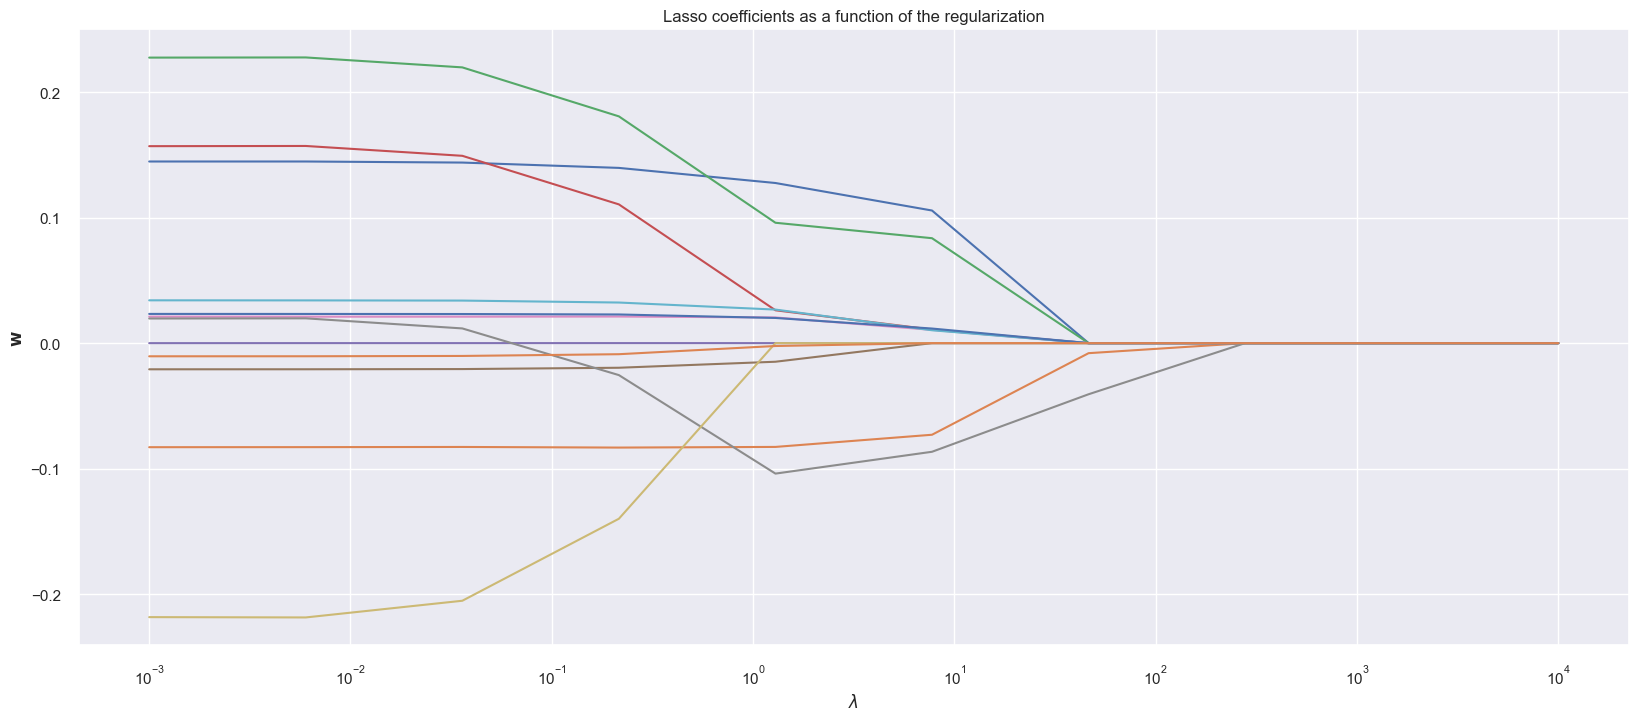

In [14]:
# instantiate 
lasso = Regression(X,y)

# plot coefficients
lasso.plot_coeff('Lasso')

<h4>3.2.4. Regularised Regression: Ridge</h4>

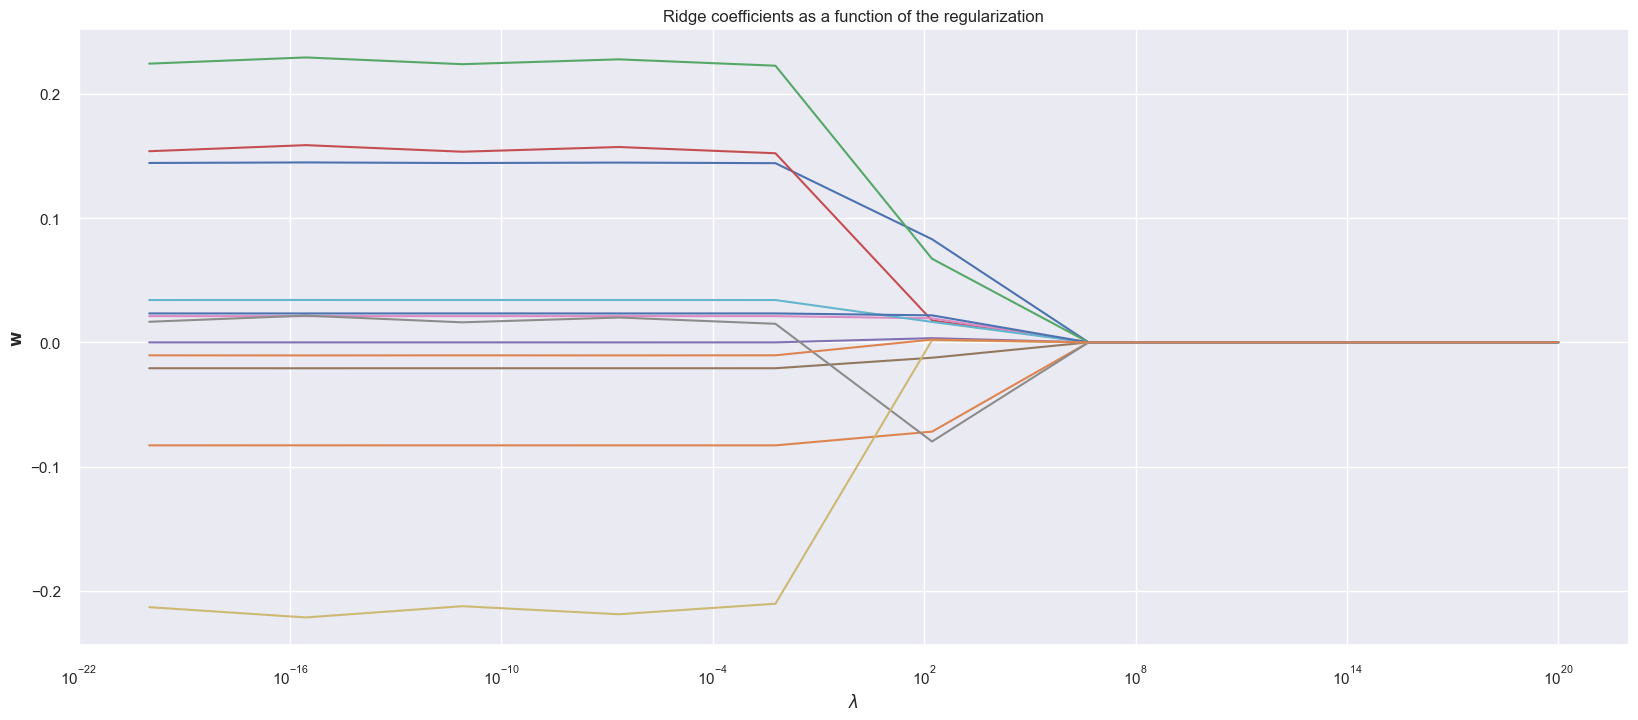

In [15]:
# instantiate 
ridge = Regression(X,y)

# plot coefficients
ridge.plot_coeff('Ridge')

<h4>3.2.5. Regularised Regression: ElasticNet</h4>

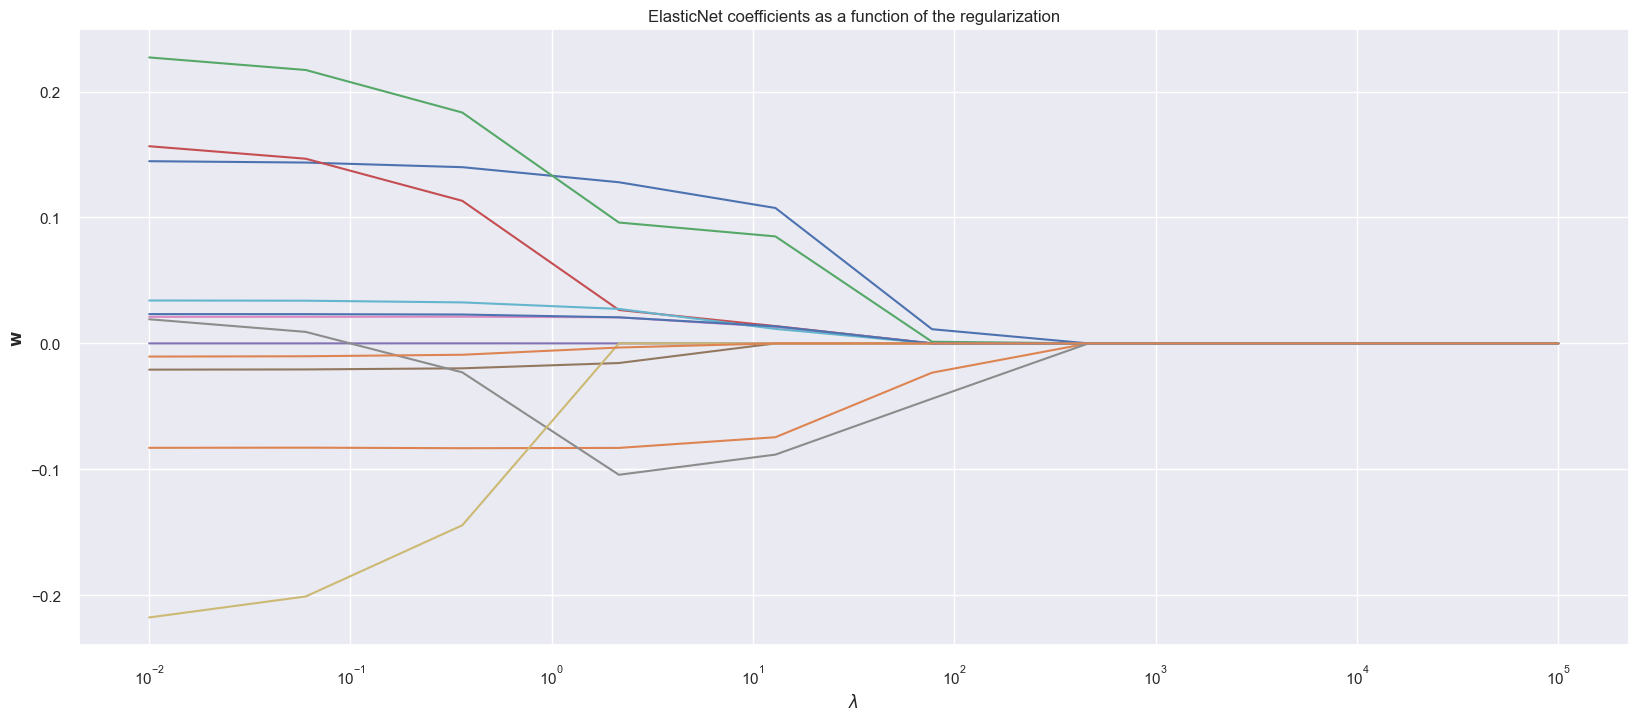

In [16]:
# instantiate 
elasticnet = Regression(X,y)

# plot coefficients
elasticnet.plot_coeff('ElasticNet')

<p>We observe a clear trend that with each of the three penalties, the coefficients reduce to zero with increasing values of $\lambda$.</p>
<p>Apply this method (instead of binary classifiers with final target of 0, 1) will allow us to observe the predictive strength of each feature. Our next step is to utilize this to select a set of features for the SVM model.</p>

<h3>3.3. Selecting Features Using Regularised Regression</h3>
<p>We now write a function that takes a range of "snapshots" in the die-off process plotted above. To do this we take a range of $\lambda$ values and list the selected features at that point.</p>

In [17]:
def coef_trend(Lbound, Ubound, model_type, num=10, obs=10):
    a_values = list(np.linspace(Lbound, Ubound, num))
    coef_values = []
    
    for a in a_values:
        if model_type == 'L':
            reg = Regression(X,y)
            model , intercept, coef, y_pred = reg.fit_predict(
                                              LogisticRegression(C=1/a,penalty='l1', 
                                                                 solver='saga'),
                                              StandardScaler()
                                                              )
        if model_type == "R":
            reg = Regression(X,y)
            model , intercept, coef, y_pred = reg.fit_predict(
                                              LogisticRegression(C=1/a,penalty='l2', 
                                                                 solver='saga'),
                                              StandardScaler()
                                                              )
            coef = [0 if c<0.0001 else c for c in coef]
        if model_type == "E":
            reg = Regression(X,y)
            model , intercept, coef, y_pred = reg.fit_predict(
                                              LogisticRegression(C=1/a, penalty='elasticnet', 
                                                                 l1_ratio=0.5,
                                                                 solver='saga'),
                                              StandardScaler()
                                                              )   
            coef = [0 if c<0.0001 else c for c in coef]
            
        coef_values.append(coef)
    
    coef_trend = pd.DataFrame(coef_values, columns=feature_names).T
    
    coef_trend.columns = a_values
    
    selected = []
    for i in range(1, obs):
        l_selected = list(coef_trend[coef_trend.iloc[:,i]>0].index)
        selected.append(l_selected)
    
    return selected

<p>Based on the coefficient plots, we select a range of $\lambda$ values for each regularised regression, and observe the behaviour of the coefficients as the $\lambda$ value moves. </p>
<p>We also "play around" with the <b>num</b> and <b>obs</b> parameters until we are able to take sufficient snapshots capturing the reduction of features. The same procedures are performed for all three Embedded selection methods.<p>
<p><b>3.3.1 LASSO variable 'Die-off' Trend</b></p>
<p>Here, we let $\lambda$ take 40 values between 0.0001 and 20, and list the selected features at each point.</p>

In [18]:
coef_trend(0.0001, 20,'L', num=40, obs=35)

[['H-L', 'RET1', 'RET2', 'RET3', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20',

<p>Store all unique combinations in a list, filter for those with 4-6 features.</p>

In [19]:
lasso_selection = [
                   ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
                   ['H-L', 'RET1', 'RET5', 'MA20', 'Momentum60'],
                   ['H-L', 'RET1', 'MA20', 'Momentum60']
                  ]

<p><b>3.3.2. Ridge variable 'Die-off'</b></p>
<p>Here, we let $\lambda$ take 40 values between 0.0001 and 2*10**5, and list the selected features at each point.</p>

In [20]:
# Ridge results
coef_trend(0.0001, 2*10**5, 'R', num=30, obs=30)

[['H-L', 'RET1', 'RET2', 'RET3', 'RET5', 'MA20', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET2', 'RET3', 'RET5', 'MA20', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET2', 'RET3', 'RET5', 'MA20', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET2', 'RET3', 'RET5', 'MA20', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET2', 'RET3', 'RET5', 'MA20', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET2', 'RET3', 'RET5', 'MA20', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET2', 'RET3', 'RET5', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET5', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET5', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET5', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET5', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET5', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET5', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET5', 'Momentum60'],
 ['H-L', 'RET1', 'RET5', 'Momentum60'],
 ['H-L', 'RET1', 'RET5', 'Momentum60'],
 ['H-L', 'RET1', 'RET5', 'Momentum60'],
 ['H-L', 'RET1

<p>Store all unique combinations in a list, filter for those with 4-6 features.</p>

In [21]:
ridge_selection = [
                   ['H-L', 'RET1', 'RET2', 'RET5', 'Momentum60', 'EMA'],
                   ['H-L', 'RET1', 'RET5', 'Momentum60', 'EMA'],
                   ['H-L', 'RET1', 'RET5', 'Momentum60'],
                ]

<p><b>3.3.2. ElasticNet variable 'Die-off'</b></p>
<p>Here, we let $\lambda$ take values between 0.0001 and 100, and list the selected features at each point.</p>

In [22]:
coef_trend(0.0001, 100, 'E', num=40, obs=22)

[['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'Momentum60'],
 ['H-L', 'RET1', 'Momentum60'],
 ['H-L', 'RET1'],
 ['H-L', 'RET1'],
 ['H-L', 'RET1'],
 ['H-L', 'RET1'],
 ['H-L', 'RET1'],
 ['H-L', 'RET1'],
 ['H-L', 'RET1'],
 ['H-L', 'RET1'],
 ['H-L', 'RET1']]

<p>Store all unique combinations in a list. Filter for those with 4-6 features.</p>

In [23]:
elasticnet_selection = [
                         ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
                         ['H-L', 'RET1', 'RET5', 'MA20', 'Momentum60']
                ]

<p>Now we complile a list of combinations derived from the penalised logistic regressions.<p>

In [24]:
embedded_selections = lasso_selection + ridge_selection + elasticnet_selection
embedded_selections

[['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET5', 'Momentum60', 'EMA'],
 ['H-L', 'RET1', 'RET5', 'Momentum60'],
 ['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60'],
 ['H-L', 'RET1', 'RET5', 'MA20', 'Momentum60']]

<h4>3.4. Wrapper Method</h4>
<p>Finally, we use wrapper methods for feature selection. We base this on the SVC algorithm and evaluates many combinations of features against the <b>F1-Score</b>. Specifically we use <b>forward selection</b> and <b>backward selection</b> methods. </p>
<p>For forward selection and backward selection, we set a <b>maximum number of 6 features and a minimum of 4 features</b>.</p>
<p>The outputs show the combinations of features selected by the algorithm.</p>

<h5>3.4.1 Forward Selection</h5>

In [25]:
def forward_selection_func(max_,min_,step=-1):   
    
    # Scaling dataset
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Feature selection
    selection = []
    for i in range(max_, min_-1, step):
        sfs=SequentialFeatureSelector(estimator = SVC()
                                          ,n_features_to_select=i,   
                                          direction='forward',
                                          cv = 5,
                                          scoring = 'f1',
                                          n_jobs=-1)
        sfs.fit(X_scaled,y)
        print(list(sfs.get_feature_names_out()))
        selection.append(list(sfs.get_feature_names_out()))
    return selection

forward_selection = forward_selection_func(6,4)

['H-L', 'Sign', 'RET2', 'RET3', 'Momentum3', 'Momentum60']
['Sign', 'RET2', 'RET3', 'Momentum3', 'Momentum60']
['Sign', 'RET2', 'RET3', 'Momentum60']


<h5>3.4.2 Backward Selection</h5>

In [26]:
def backward_selection_func(max_,min_,step=-1): 
    
    # Scaling dataset
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Feature selection
    selection = []
    for i in range(max_, min_-1, step):
        sfs=SequentialFeatureSelector(estimator = SVC()
                                          ,n_features_to_select=i,   
                                          direction='backward',
                                          cv = 5,
                                          scoring = 'f1',
                                          n_jobs=-1)
        sfs.fit(X_scaled,y)
        print(list(sfs.get_feature_names_out()))
        selection.append(list(sfs.get_feature_names_out()))
    return selection

backward_selection = backward_selection_func(6,4)

['Sign', 'RET2', 'RET4', 'RET5', 'Momentum3', 'MA20']
['Sign', 'RET2', 'RET5', 'Momentum3', 'MA20']
['Sign', 'RET2', 'Momentum3', 'MA20']


<p>Combine the wrapper selection results into a list of combinations.<p>

In [27]:
wrapper_selections = forward_selection + backward_selection

<h3>3.5. Final Feature Sets</h3>
<p>Finally, we combine results of the Embedded methods and the Wrapper methods as the full set of feature combinations <b>trial_set</b> to input into the SVM model.</p>

In [28]:
trial_sets = embedded_selections + wrapper_selections

<p>Removing duplicate combinations.</p>

In [29]:
trial_sets_nodup = []

for set_ in trial_sets:
    if set_ not in trial_sets_nodup:
        trial_sets_nodup.append(set_)
        print(set_)


['H-L', 'RET1', 'RET2', 'RET5', 'MA20', 'Momentum60']
['H-L', 'RET1', 'RET5', 'MA20', 'Momentum60']
['H-L', 'RET1', 'MA20', 'Momentum60']
['H-L', 'RET1', 'RET2', 'RET5', 'Momentum60', 'EMA']
['H-L', 'RET1', 'RET5', 'Momentum60', 'EMA']
['H-L', 'RET1', 'RET5', 'Momentum60']
['H-L', 'Sign', 'RET2', 'RET3', 'Momentum3', 'Momentum60']
['Sign', 'RET2', 'RET3', 'Momentum3', 'Momentum60']
['Sign', 'RET2', 'RET3', 'Momentum60']
['Sign', 'RET2', 'RET4', 'RET5', 'Momentum3', 'MA20']
['Sign', 'RET2', 'RET5', 'Momentum3', 'MA20']
['Sign', 'RET2', 'Momentum3', 'MA20']


<h2>Section 4. Support Vector Machine</h2>
<h3>Section 4.1. Model Selection</h3>

<p>Next, we perform a grid search to find the best SVM predictor of the target label.</p>
<p>We define a SupportVectorModel class which takes in three arguments as Class Properties: independent features dataframe X, target Label vector y, and the test size as a proportion to the sample size.</p> 
<p>The <b>"fit_predict_evaluate"</b> function performs a grid search on the parameter grid <b>"param_grid"</b> that is passed to the function as an argument. The function splits the sample according to the test size property, scales the dataset, and performs the grid search. The function returns a dictionary storing the best parameters of the model found in the grid search, accuracy on the training dataset, accuracy on the test dataset, F1 Score, Precision Score and Recall Score. </p>

In [30]:
from sklearn.metrics import recall_score, precision_score, f1_score

class SupportVectorModel:
    def __init__(self, X, y, testsize=0.20):
        self.X = X
        self.y = y
        self.testsize = testsize
        
        # split training and testing dataset
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, 
                                                                                self.y, 
                                                                                test_size=self.testsize, 
                                                                                random_state=0, 
                                                                                shuffle=False)
        self.model = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('svm', SVC())
        ])
    
     # fit and predict 
    def fit_predict_evaluate(self, param_grid):
        try:
            #
            # implement grid search
            grid = GridSearchCV(self.model,param_grid,verbose=0, cv=3)
            
            # fit/train model
            grid.fit(self.X_train, self.y_train)
            
            # get best parameters and best estimator
            best_params = grid.best_params_
            best_model = grid.best_estimator_
            print(f'Best Parameters: {best_params}')
            
            # Predicting the test dataset
            y_pred = best_model.predict(self.X_test)
            
            # calculate accuracy
            acc_train = accuracy_score(self.y_train, best_model.predict(self.X_train))
            acc_test = accuracy_score(self.y_test, y_pred)
            recall = recall_score(self.y_test, y_pred)
            precision = precision_score(self.y_test, y_pred)
            f1 = f1_score(self.y_test, y_pred)
            
        except Exception as e:
            print(str(e))  
            
        return {'Best Parameters': best_params,
               'Training Accuracy': acc_train,
               'Test Accuracy': acc_test,
               'F1': f1,
               'Precision': precision,
               'Recall': recall
               }
        

<p>Next we define a parameter grid for grid search.</p>

In [31]:
param_grid = [
    {
        'svm__C': [0.1, 1, 10, 100], 
        'svm__kernel': ['sigmoid'], 
        'svm__gamma': [1,0.1,0.01,0.001], 
        'svm__coef0': [0.0, 0.5, 1.0, 1.5, 2.0]},
    {
        'svm__C': [0.1, 1, 10, 100], 
        'svm__gamma': [1,0.1,0.01,0.001], 
        'svm__kernel': ['rbf']},
    ]

<p>We then run the grid search and best model prediction process. The grid search is run for each set of features in the <b>trial_sets</b> list.</p> The outputs are stored in three lists: </p>
<ul>
    <li><b>training_accuracy</b> stores the model's accuracy on the training set for the best model found each round of the grid search.</li>
    <li><b>test_accuracy</b> stores the model's accuracy on the testing set for the best model found on each round of grid search.</li>
    <li><b>best_params</b> stores the set of model parameters for the best model found on each round of the grid search.</li>
    <li><b>precision</b> stores the precision score for the model found in each round of the grid search.</li>
    <li><b>precision</b> stores the recall score for the model found in each round of the grid search.</li>
    <li><b>f1</b> stores the F1 score for the model found in each round of the grid search.</li>
</ul>

In [32]:
# Initiating empty list to store outputs
training_accuracy = []
test_accuracy = []
best_params = []
precision = []
recall = []
f1 = []

# Running a grid search for each set of features selected in Section 3
for set_ in trial_sets_nodup:
    SVM = SupportVectorModel(X[set_], y)
    result = SVM.fit_predict_evaluate(param_grid)
    training_accuracy.append(result['Training Accuracy'])
    test_accuracy.append(result['Test Accuracy'])
    best_params.append(result['Best Parameters'])
    precision.append(result['Precision'])
    recall.append(result['Recall'])
    f1.append(result['F1'])
    
# Storing results in a dataframe
grid_search_results = pd.DataFrame.from_dict({
    "Features": trial_sets_nodup,
    "Training Accuracy": training_accuracy,
    'Test Accuracy':test_accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Best Parameters': best_params
})

Best Parameters: {'svm__C': 10, 'svm__coef0': 0.5, 'svm__gamma': 0.1, 'svm__kernel': 'sigmoid'}
Best Parameters: {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best Parameters: {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best Parameters: {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best Parameters: {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best Parameters: {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best Parameters: {'svm__C': 10, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Best Parameters: {'svm__C': 10, 'svm__coef0': 0.0, 'svm__gamma': 0.01, 'svm__kernel': 'sigmoid'}
Best Parameters: {'svm__C': 100, 'svm__coef0': 0.0, 'svm__gamma': 0.001, 'svm__kernel': 'sigmoid'}
Best Parameters: {'svm__C': 100, 'svm__coef0': 0.0, 'svm__gamma': 0.001, 'svm__kernel': 'sigmoid'}
Best Parameters: {'svm__C': 10, 'svm__coef0': 0.0, 'svm__gamma': 0.01, 'svm__kernel': 'sigmoid'}
Best Parameters: {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel

<p><b>Discovering best parameters: </b></p>
<p>First, we examine the output dataframe and locate when the model performs best. Then using the parameters of the "best model", we instantiate another SVC model and run it on our dataset to produce final results.</p> 

In [33]:
grid_search_results

,Features,Training Accuracy,Test Accuracy,Precision,Recall,F1 Score,Best Parameters
0,"[H-L, RET1, RET2, RET5, MA20, Momentum60]",0.503979,0.464191,0.444954,0.544944,0.489899,"{'svm__C': 10, 'svm__coef0': 0.5, 'svm__gamma'..."
1,"[H-L, RET1, RET5, MA20, Momentum60]",0.557029,0.498674,0.471204,0.505618,0.487805,"{'svm__C': 100, 'svm__gamma': 0.01, 'svm__kern..."
2,"[H-L, RET1, MA20, Momentum60]",0.545756,0.482759,0.459716,0.544944,0.498715,"{'svm__C': 100, 'svm__gamma': 0.01, 'svm__kern..."
3,"[H-L, RET1, RET2, RET5, Momentum60, EMA]",0.582891,0.458886,0.450382,0.662921,0.536364,"{'svm__C': 100, 'svm__gamma': 0.01, 'svm__kern..."
4,"[H-L, RET1, RET5, Momentum60, EMA]",0.558355,0.482759,0.459716,0.544944,0.498715,"{'svm__C': 10, 'svm__gamma': 0.01, 'svm__kerne..."
5,"[H-L, RET1, RET5, Momentum60]",0.543767,0.493369,0.467980,0.533708,0.498688,"{'svm__C': 100, 'svm__gamma': 0.01, 'svm__kern..."
6,"[H-L, Sign, RET2, RET3, Momentum3, Momentum60]",0.539125,0.543767,0.515152,0.573034,0.542553,"{'svm__C': 10, 'svm__gamma': 0.001, 'svm__kern..."
7,"[Sign, RET2, RET3, Momentum3, Momentum60]",0.538462,0.543767,0.515152,0.573034,0.542553,"{'svm__C': 10, 'svm__coef0': 0.0, 'svm__gamma'..."
8,"[Sign, RET2, RET3, Momentum60]",0.539125,0.543767,0.515152,0.573034,0.542553,"{'svm__C': 100, 'svm__coef0': 0.0, 'svm__gamma..."
9,"[Sign, RET2, RET4, RET5, Momentum3, MA20]",0.539125,0.543767,0.515152,0.573034,0.542553,"{'svm__C': 100, 'svm__coef0': 0.0, 'svm__gamma..."


<p>From the results we can see that amongst the "best" models, some feature sets perform better than others. Taking into account a balanced combination of all metrics (where all metrics score > 0.5), the best-performing models are extracted below. Note that although the model at Index 10 has the highest F1 Score, the test accuracy and precision score are both less than 0.5. The F1 Score is clearly driven by the high recall of 0.758. A high recall means that the model is able to capture most positives. However this alone isn't sufficient to make a good model as in the case of predicting ticker prices, both the positive and negative classification accuracy matters (unlike classifying disease cases), hence we'd want a model that has a balanced performance in predicting growth and drop. A low test accuracy of 0.49 also suggests that the model could be overfitting. </p>

In [42]:
# Best performing models
grid_search_results.loc[[6,8,9],:]

,Features,Training Accuracy,Test Accuracy,Precision,Recall,F1 Score,Best Parameters
6,"[H-L, Sign, RET2, RET3, Momentum3, Momentum60]",0.539125,0.543767,0.515152,0.573034,0.542553,"{'svm__C': 10, 'svm__gamma': 0.001, 'svm__kern..."
8,"[Sign, RET2, RET3, Momentum60]",0.539125,0.543767,0.515152,0.573034,0.542553,"{'svm__C': 100, 'svm__coef0': 0.0, 'svm__gamma..."
9,"[Sign, RET2, RET4, RET5, Momentum3, MA20]",0.539125,0.543767,0.515152,0.573034,0.542553,"{'svm__C': 100, 'svm__coef0': 0.0, 'svm__gamma..."


<p>With the three models performing equally, we select the one with the least number of features.</p>
<p>The set of features are: ["Sign", "RET2", "RET3", "Momentum60"]</p>

In [43]:
grid_search_results.loc[[8],:]

,Features,Training Accuracy,Test Accuracy,Precision,Recall,F1 Score,Best Parameters
8,"[Sign, RET2, RET3, Momentum60]",0.539125,0.543767,0.515152,0.573034,0.542553,"{'svm__C': 100, 'svm__coef0': 0.0, 'svm__gamma..."


In [44]:
# Storing selected features into a list
model_features = ["Sign", "RET2", "RET3", "Momentum60"]

<p>Extracting the parameters</p>

In [45]:
print(np.array(grid_search_results.loc[[8],['Best Parameters']]))

[[{'svm__C': 100, 'svm__coef0': 0.0, 'svm__gamma': 0.001, 'svm__kernel': 'sigmoid'}]]


<p>The parameters for the 'best' model are:</p>
<ul>
    <li>C = 100</li>
    <li>gamma = 0.001</li>
    <li>kernel = "sigmoid:</li>
    <li>coef0 = 0.0</li>
</ul>

<h3>Section 4.2. Model Fitting and Metrics</h3>
<h4>4.2.1. Model Fitting</h4>
<p>Now we instantiate an SVM model with the best model parameters, fit the model with our dataset, and run predictions on the test sample.</p>

In [46]:
# Splitting Training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X[model_features], y, 
                                                    test_size=0.2, random_state=0)

# Creating pipeline
model = Pipeline([
    ('scaler', StandardScaler()),  # Standard Scaler
    ('svm', SVC(C=100, gamma=0.001, 
                kernel='sigmoid',coef0=0.0))  # SVM model with Best parameters
])

# Fit the pipeline on the training data
model.fit(X_train, y_train)

# Predict test dataset
y_pred = model.predict(X_test)

<h4>4.2.2 Evaluating Metrics</h4>
<h5>Confusion Matrix</h5>

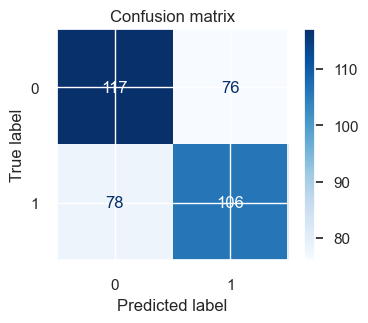

In [47]:
# Display confusion matrix
sns.set(rc={'figure.figsize':(4,3)})
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=model.classes_,
        cmap=plt.cm.Blues
)
disp.ax_.set_title('Confusion matrix')
plt.show()

<h6>Interpreting Confusion Matrix</h6>
<p>From the matrix we can see the model predicts: <b>117 True positives, 76 False Positives, 78 False Negatives, 106 True Negatives</b>.</p>

<h5>Classification Report</h5>

In [48]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.61      0.60       193
           1       0.58      0.58      0.58       184

    accuracy                           0.59       377
   macro avg       0.59      0.59      0.59       377
weighted avg       0.59      0.59      0.59       377



<h6>Interpreting Classification Report</h6>
<p><b>Precision</b> of 0.58 for positives and 0.60 for negatives: amongst the total number of positive predictions, around 58% are correct, amongst total number of negative predictions around 60% are correct.</p>
<p><b>Recall</b> of 0.58 for positives and 0.61 for negatives: amongst the total number of actual positives, 58% are correctly predicted, and amongst the total number of actual negatives, 61% are correctly predicted.</p>
<p><b>F1 Score</b> of 0.58 for positives and 0.60 for negatives: The average between recall and precision is 0.58 for positives and 0.60 for negatives. </p>
<p>Overall the model performance is only slighly above average, (it's not an awful model but not so great either) with the F1 score of 0.60 being a all-rounded measure of model accuracy.</p>

<h5>ROC Curve</h5>

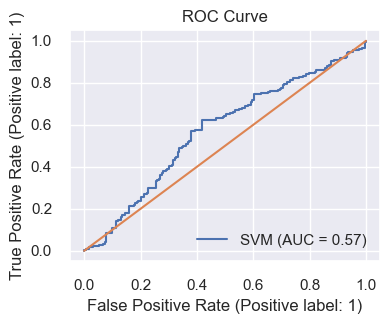

In [49]:
# Display ROC Curve
disp_roc = RocCurveDisplay.from_estimator(

            model,
            X_test,
            y_test,
            name='SVM'
        )
disp_roc.ax_.set_title('ROC Curve')
plt.plot([0,1], [0,1])
plt.show()

<h6>Interpreting ROC Curve</h6>
<p>With an AUC (area under the curve) of 0.57, the model performs slighly better than a random model at distinguishing between the positive and positives and negatives. from the blue line we can see that moving along the horizontal axis (different classification thresholds), the curve stays mostly above the 0.5 benchmark except near the boundaries, indicating the model has overall some predictive power.</p>
<p>Comparing with industry practices, an AUC of 0.5-0.7 is considered poor discrimination.</p>

<p><b>Overall this is a bad model. Which aligns with the common agreement that one cannot predict future financial outcomes with past data...</b><p>